# Anime Recommendation Systems

## Import Libraries

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import os
import re
import sys
from scipy.sparse import csr_matrix
import warnings

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## scikit modeling libraries
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#Preparing folder variables
os.chdir(os.path.dirname(sys.path[0])) # This command makes the notebook the main path and can work in cascade.
main_folder = sys.path[0]


data_folder = (main_folder + "\data")

In [6]:
import os
import sys
os.chdir(os.path.dirname(sys.path[0])) # This command makes the notebook the main path and can work in cascade.
main_folder = sys.path[1]

In [7]:
main_folder

'c:\\Users\\Chrisitan\\AppData\\Local\\Programs\\Python\\Python38\\python38.zip'

## Loading the data

In [1]:
import os

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))
from utils import cleaning

c:\Users\Chrisitan\AppData\Local\Programs\Python\Python38\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


ReadError: d:\Github\Anime_recommendation_system\src/data/processed/pivot_user_based_unsupervised.zip is not a zip file

In [22]:
animedf = pd.read_csv(data_folder + "/" + "anime.csv")
ratingdf = pd.read_csv(data_folder + "/" + "rating.csv.zip")

## Let's check information of anime dataset

In [3]:
animedf.head(5)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.16,151266


In [4]:
animedf.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [5]:
print ("The shape of the anime data is (row, column):"+ str(animedf.shape))
print (animedf.info())

The shape of the anime data is (row, column):(12294, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None


## Let's check information of rating dataset

In [6]:
print ("The shape of the rating data is (row, column):"+ str(animedf.shape))
print (ratingdf.info())

The shape of the rating data is (row, column):(12294, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


## Merging dataframes

In [7]:
animedf['name'] = animedf['name'].str.lower()
merged_df=pd.merge(animedf,ratingdf,on='anime_id',suffixes= ['', '_user'])
merged_df = merged_df.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})
merged_df.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813727 entries, 0 to 7813726
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   anime_title  object 
 2   genre        object 
 3   type         object 
 4   episodes     object 
 5   rating       float64
 6   members      int64  
 7   user_id      int64  
 8   user_rating  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 596.1+ MB


## Checking and Cleaning data

C:\Users\christiandda\AppData\Local\Temp\ipykernel_16120\3155341435.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = merged_df.corr()


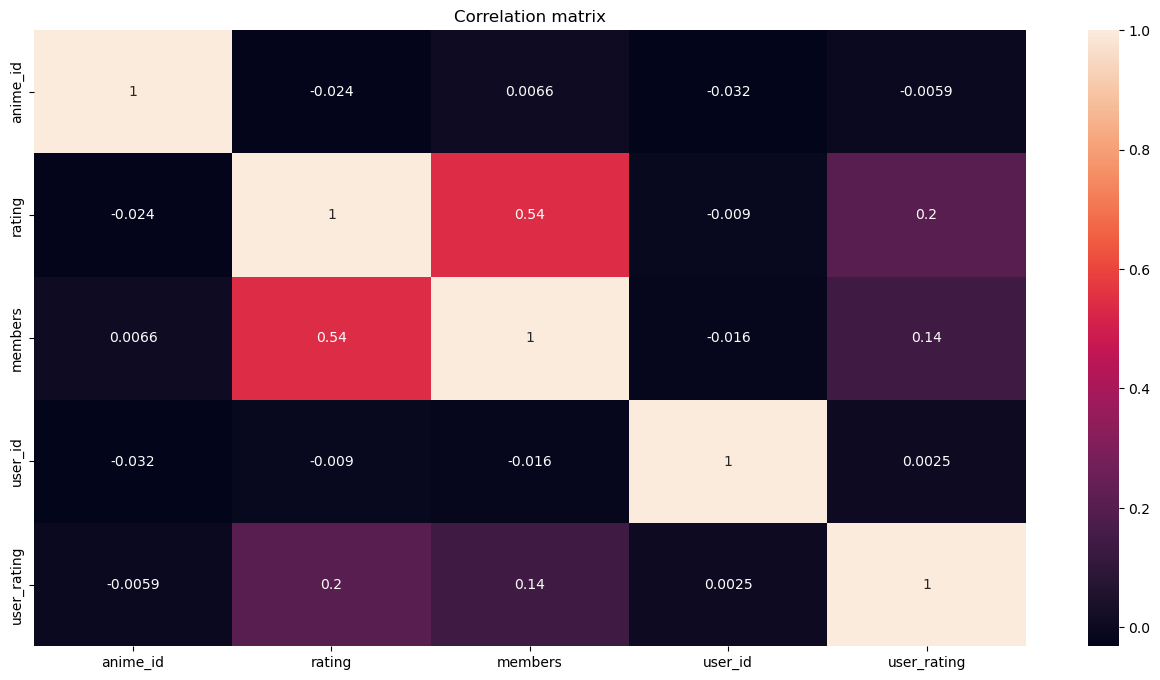

In [9]:
# Checking possible correlations for future studies.
plt.rc("figure", figsize=(16,8))
corr = merged_df.corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()
plt.close()# Close the plot

### Handling NaN values

In [10]:
merged_df.isnull().sum()

anime_id         0
anime_title      0
genre          110
type             4
episodes         0
rating           6
members          0
user_id          0
user_rating      0
dtype: int64

In [11]:
merged_df['genre'].fillna(merged_df['genre'].mode()[0], inplace=True)

In [12]:
merged_df['type'].fillna(merged_df['type'].mode()[0], inplace=True)

In [13]:
merged_df['rating'] = merged_df['rating'].interpolate(method = "spline", order = 1,  limit_direction = "both", downcast = "infer")

### Removing user_rating with no rating

In [14]:
#Replacing -1 values in user_rating column for Nan values
merged_df["user_rating"].replace({-1: np.nan}, inplace=True)

In [15]:
merged_df.isnull().sum()

anime_id             0
anime_title          0
genre                0
type                 0
episodes             0
rating               0
members              0
user_id              0
user_rating    1476488
dtype: int64

In [16]:
#Droping NaN values
merged_df = merged_df.dropna(axis = 0, how ='any') 

In [17]:
merged_df.isnull().sum()

anime_id       0
anime_title    0
genre          0
type           0
episodes       0
rating         0
members        0
user_id        0
user_rating    0
dtype: int64

In [18]:
features=merged_df.copy()

features.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
5,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10.0


### Checking user_id iformation

In [19]:
features['user_id'].value_counts()
counts = features['user_id'].value_counts()
features = features[features['user_id'].isin(counts[counts >= 200].index)]

### Pivoting

In [20]:
pivot_df=features.pivot_table(index='anime_title',columns='user_id',values='user_rating').fillna(0)
pivot_df.head()

user_id                                              5      7      17     \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              38     43     46     \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              123    129    139    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              160    210    226    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    7.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     8.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       8.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              233    235    244    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              248    250    256    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              261    271    282    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              288    294    301    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu

# Building The Recommendation Systems

## Collaborative Filtering

User-based: (Este es el que veremos a continuación)
- Se identifican usuarios similares
- Se recomiendan nuevos ítems a otros usuarios basado en el rating dado por otros usuarios similares (que no haya valorado este usuario)

### Cosine Similarity using KNN V.1

In [23]:
##create a dataframe with all training data except the target column
#X = features.drop(columns=["anime_title"])
##check that the target variable has been removed
##X.head()
#
##separate target values
#y = features["anime_title"].values
##view target values
##y[0:5]
#
## Split the dataset into train and test data
#
#from sklearn.model_selection import train_test_split
##split dataset into train and test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7,random_state=1234, stratify=y)
#
## Building and training the model
#
#from sklearn.neighbors import KNeighborsClassifier
## Create KNN classifier
#knn = KNeighborsClassifier(n_neighbors = 3)
## Fit the classifier to the data
#knn.fit(X_train,y_train)
#
## Testing the model
#
##show first 5 model predictions on the test data
#print(knn.predict(X_test)[0:5])
#
##check accuracy of our model on the test data
#print(knn.score(X_test, y_test))

In [24]:
# Creating a sparse matrix
matrix = csr_matrix(pivot_df.values)

In [29]:
# Building and training the model

from sklearn.neighbors import KNeighborsClassifier
#Everything after the first column is a feature
X = matrix[:,1:]
#The first column is the target variable
Y = pd.DataFrame(matrix[:,0].astype(int).todense())

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = \
    train_test_split(X,Y, test_size=0.2, random_state=888)

In [ ]:
# Building an XGBoost Model

In [25]:
features.head(2)

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
2,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0


In [28]:
numeric_df = features[[
    'anime_id', 'episodes', 'rating', 'members', 'user_id', 'user_rating'
]].melt(id_vars = 'anime_id')
text_df = features[[
    "anime_id",'anime_title', 'genre',"type"
]].melt(id_vars = 'anime_id')

text_df.variable = text_df.variable + '_' + text_df.value

#Remove special characters from variable names
text_df.variable = \
    text_df.variable.str.replace('\[|\)', '', regex = True)
text_df = text_df.assign(value = 1)
tall_df = numeric_df.append(text_df)

C:\Users\christiandda\AppData\Local\Temp\ipykernel_2012\2070058043.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tall_df = numeric_df.append(text_df)


In [38]:
from pandas.api.types import CategoricalDtype
encounter_c = CategoricalDtype(sorted(tall_df.anime_id.unique()), ordered=True)
var_c = CategoricalDtype(sorted(tall_df.variable.unique()), ordered=True)
row = tall_df.anime_id.astype(encounter_c).cat.codes
col = tall_df.variable.astype(var_c).cat.codes


In [46]:
tall_df["variable"].unique()

array(['episodes', 'rating', 'members', ..., 'type_Special', 'type_Music',
       'type_ONA'], dtype=object)

In [37]:
sparse_matrix = \
    csr_matrix(
        ( tall_df["value"], (row, col) )
        , shape = ( encounter_c.categories.size, var_c.categories.size )
    )

ValueError: object dtype is not supported by sparse matrices

In [42]:
#Everything after the first column is a feature
X = sparse_matrix[:,1:]
#The first column is the target variable
Y = pd.DataFrame(sparse_matrix[:,0].astype(int).todense())
X_train, X_test, Y_train, Y_test = \
    train_test_split(X,Y, test_size=0.2, random_state=888)

NameError: name 'sparse_matrix' is not defined

In [34]:
from xgboost.sklearn import XGBClassifier
import pandas as pd, xgboost as xgb
xgb_model = \
    xgb.XGBClassifier(
        objective='binary:logistic'
        ,booster='gbtree'
        ,tree_method='auto'
        ,eval_metric='logloss'
        ,n_jobs=4
        ,max_delta_step=0
        ,random_state=888
        ,verbosity=1
    )
xgb_model.fit(X_train, Y_train)

NameError: name 'X_train' is not defined

In [ ]:
# Fitting the matrix
model_knn = NearestNeighbors(15, metric = 'cosine', algorithm = 'brute')
model_knn.fit(matrix)
matrix

In [ ]:
# Getting a random anime tittle
index = np.random.choice(pivot_df.shape[0])
print(index)

In [ ]:
# Finding the recommendation for the randomly chosen anime tittle
distances, indices = model_knn.kneighbors(pivot_df.iloc[index,:].values.reshape(1, -1), n_neighbors = 6)

In [ ]:
# Returning the distances and indices of 6 neighbours through KNN from the randomly chosen anime tittle (from the Index)
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(pivot_df.index[index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, pivot_df.index[indices.flatten()[i]], distances.flatten()[i]))

### Cosine Similarity using KNN V.2

In [ ]:
merged_df.head(5)
print(merged_df["type"].unique())
merged_df['type'].isna()

In [ ]:
# Using apply() method to combine two columns of text to create a combined_features column
merged_df["combined_features"] = merged_df[["genre", "type"]].apply(", ".join, axis=1)
merged_df.head(5)

In [ ]:
# Extracting Features
cv = CountVectorizer()
count_matrix = cv.fit_transform(merged_df["combined_features"])
print("Count Matrix:", count_matrix.toarray())
cosine_sim = cosine_similarity(count_matrix)

In [ ]:
# Content User likes

movie_user_likes = "Dead Poets Society"
def get_index_from_title(title):
    return merged_df[merged_df.title == title]["index"].values[0]
movie_index = get_index_from_title(movie_user_likes)

In [ ]:
# Generating the Similar Movies Matrix
similar_movies = list(enumerate(cosine_sim[movie_index]))

In [ ]:
# Sorting the Similar Movies List in Descending Order
sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)

In [ ]:
# Printing the Similar Movies
def get_title_from_index(index):
    return merged_df[merged_df.index == index]["title"].values[0]
i=0
for movie in sorted_similar_movies:
    print(get_title_from_index(movie[0]))
    i=i+1
    if i>15:
        break

In [ ]:
get_title_from_index("Dead Poets Society")

### Cosine Similarity using KNN V.3

In [1]:
import pandas as pd
import numpy as np
import os
import re
#Preparing folder variables
os.chdir(os.path.dirname(sys.path[0])) # This command makes the notebook the main path and can work in cascade.
main_folder = sys.path[0]
data_folder = (main_folder + "\data")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import sklearn

In [5]:
animedf = pd.read_csv(data_folder + "/" + "anime.csv")
ratingdf = pd.read_csv(data_folder + "/" + "rating.csv.zip")

In [7]:
animedf.head(2)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665


In [6]:
ratingdf.head(2)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1


In [ ]:
n_users = ratingdf.user_id.unique().shape[0]
n_items = ratingdf.anime_id.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

In [ ]:
# Creamos la matriz usuarios/ratings
df_matrix = pd.pivot_table(ratingdf, values='rating', index='user_id', columns='anime_id').fillna(0)

In [ ]:
# Sparcity
# Veamos el porcentaje de sparcity que tenemos:
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.43%


In [ ]:
# Dividimos en Train y Test set
# Separamos en train y test para más adelante poder medir la calidad de nuestras recomendaciones.

ratings_train, ratings_test = train_test_split(ratings, test_size = 0.7, random_state=42)
print(ratings_train.shape)
print(ratings_test.shape)

(24, 167)
(6, 167)


In [ ]:
# Matriz de Similitud: Distancias por Coseno
# Ahora calculamos en una nueva matriz la similitud entre usuarios.
# Cuanto más cercano a 1, mayor similitud entre esos usuarios

similitud_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)
print(similitud_matrix.shape)

(30, 30)


In [ ]:
similitud_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)
print(similitud_matrix.shape)

(30, 30)


In [ ]:
# Predicciones -ó llamémosle “Sugeridos para ti”-

#separar las filas y columnas de train y test
similitud_matrix_train = similitud_matrix[0:24,0:24]
similitud_matrix_test = similitud_matrix[24:30,24:30]

users_predictions = similitud_matrix_train.dot(ratings_train) / np.array([np.abs(similitud_matrix_train).sum(axis=1)]).T



In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions)
plt.colorbar()
plt.show()

In [ ]:
USUARIO_EJEMPLO = 'jbagnato'
data = ratingdf[ratingdf['user_id'] == 1]
usuario_ver = data.iloc[0]['userId'] - 1 # resta 1 para obtener el index de pandas.

user0=users_predictions.argsort()[usuario_ver]

# Veamos los tres recomendados con mayor puntaje en la predic para este usuario
for i, aRepo in enumerate(user0[-3:]):
    selRepo = user_id[user_id['repoId']==(aRepo+1)]
    print(selRepo['title'] , 'puntaje:', users_predictions[usuario_ver][aRepo])

23    ansible / ansible
Name: title, dtype: object puntaje: 1.6300984296308052
6    pallets / flask
Name: title, dtype: object puntaje: 3.124047243895186
13    python / cpython
Name: title, dtype: object puntaje: 4.998475590232298


In [ ]:
# Validemos el error
# Sobre el test set comparemos el mean squared error con el conjunto de entrenamiento:
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

get_mse(users_predictions, ratings_train)

# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[24:30,:]

get_mse(users_predictions_test, ratings_test)

8.902416522040543

In [2]:
df_users = pd.read_csv(data_folder + "/" + "users.csv")
df_repos = pd.read_csv(data_folder + "/" + "repos.csv")
df_ratings = pd.read_csv(data_folder + "/" + "ratings.csv")

In [3]:
df_users.head(2)

,userId,username,name
0,1,iris9112,Isabel Ruiz Buriticá
1,2,dianaclarke,Diana


In [14]:
n_users = df_ratings.userId.unique().shape[0]
n_items = df_ratings.repoId.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

30 users
167 items


In [ ]:
# Creamos la matriz usuarios/ratings
df_matrix = pd.pivot_table(df_ratings, values='rating', index='userId', columns='repoId').fillna(0)


In [16]:
# Sparcity
# Veamos el porcentaje de sparcity que tenemos:
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.43%


In [17]:
# Dividimos en Train y Test set
# Separamos en train y test para más adelante poder medir la calidad de nuestras recomendaciones.

ratings_train, ratings_test = train_test_split(ratings, test_size = 0.7, random_state=42)
print(ratings_train.shape)
print(ratings_test.shape)

(24, 167)
(6, 167)


In [18]:
# Matriz de Similitud: Distancias por Coseno
# Ahora calculamos en una nueva matriz la similitud entre usuarios.
# Cuanto más cercano a 1, mayor similitud entre esos usuarios

similitud_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)
print(similitud_matrix.shape)

(30, 30)


In [19]:
similitud_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)
print(similitud_matrix.shape)

(30, 30)


In [20]:
# Predicciones -ó llamémosle “Sugeridos para ti”-

#separar las filas y columnas de train y test
sim_matrix_train = sim_matrix[0:24,0:24]
sim_matrix_test = sim_matrix[24:30,24:30]

users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T



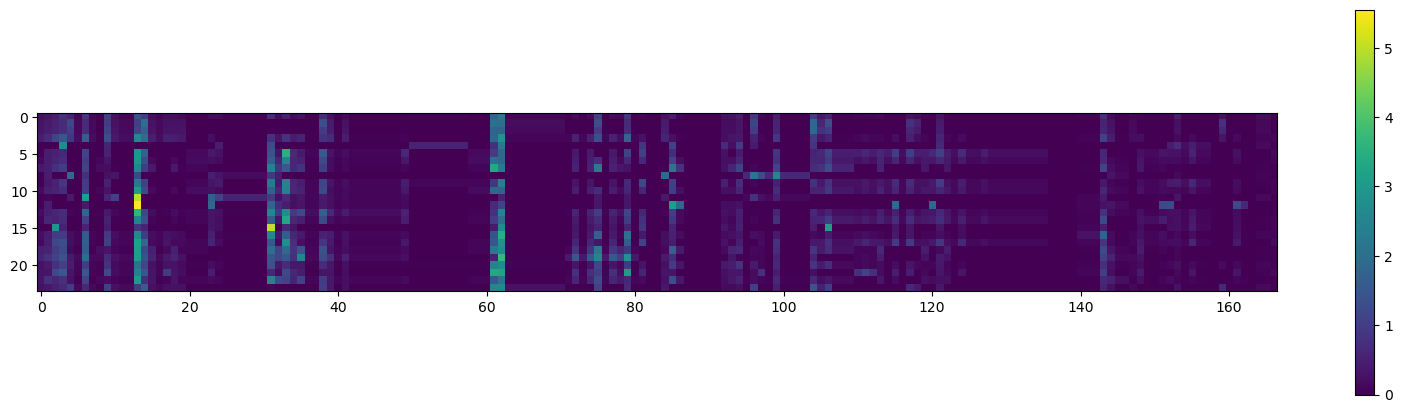

In [23]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

In [24]:
USUARIO_EJEMPLO = 'jbagnato'
data = df_users[df_users['username'] == USUARIO_EJEMPLO]
usuario_ver = data.iloc[0]['userId'] - 1 # resta 1 para obtener el index de pandas.

user0=users_predictions.argsort()[usuario_ver]

# Veamos los tres recomendados con mayor puntaje en la predic para este usuario
for i, aRepo in enumerate(user0[-3:]):
    selRepo = df_repos[df_repos['repoId']==(aRepo+1)]
    print(selRepo['title'] , 'puntaje:', users_predictions[usuario_ver][aRepo])

23    ansible / ansible
Name: title, dtype: object puntaje: 1.6300984296308052
6    pallets / flask
Name: title, dtype: object puntaje: 3.124047243895186
13    python / cpython
Name: title, dtype: object puntaje: 4.998475590232298


In [25]:
# Validemos el error
# Sobre el test set comparemos el mean squared error con el conjunto de entrenamiento:
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

get_mse(users_predictions, ratings_train)

# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[24:30,:]

get_mse(users_predictions_test, ratings_test)

8.902416522040543

## Content based filtering